# Classical Shadow Transformer

## Initialization

In [33]:
%run 'CST.py'
import matplotlib.pyplot as plt
import pickle
device = torch.device('cpu') # 'cpu', 'cuda', 'mps' ...

## Testing

### Transformer

#### Test 1: Log Probability Estimation

**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

Create a model and put into evaluation mode (to disable dropout).

In [115]:
tf = Transformer(outtk_size=2)
tf.eval()
x = torch.tensor([[4],[4],[5],[5],[6],[6]])

In [116]:
y, logprob = tf.sample(x, 1, need_logprob=True)
y, logprob

(tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [2]]),
 tensor([-0.1394, -0.1394, -0.2494, -0.2494, -0.2867, -1.3893]))

In [117]:
tf.logprob(x, y)

tensor([-0.1394, -0.1394, -0.2494, -0.2494, -0.2867, -1.3893],
       grad_fn=<SumBackward1>)

Results are matched up.

#### Test 2: Generative Modeling

**Goal:** test the ability of the transformer model to learn sequence-to-sequence map.

In [118]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [119]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [138]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss = -tf.logprob(x, y).mean()
    loss.backward()
    optimizer.step()
    print('{:3d}: {:8.5g}'.format(epoch, loss.item()))

  0:   0.4342
  1:   0.4614
  2:  0.52217
  3:  0.48025
  4:  0.43548
  5:  0.44449
  6:  0.47305
  7:  0.45674
  8:  0.49512
  9:  0.46951


Learns to predict $y$ from $x$.

In [139]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9981397390365601,
 0.0018602701602503657,
 0.4812822937965393,
 0.5187177062034607,
 0.3203440308570862,
 0.6796560287475586,
 0.6796559691429138]

#### Test 3: VAE loss

**Goal**: test training the transformer with VAE bottleneck

In [142]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [279]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [305]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss, logprob, kld = tf.loss(x, y, beta=0.)
    loss.backward()
    optimizer.step()
    print(f'{epoch:3d}: {loss.item():8.5g} {logprob.item():8.5g} {kld.item():8.5g}')

  0:  0.47548 -0.47548 0.088517
  1:  0.47102 -0.47102 0.084518
  2:  0.47253 -0.47253  0.08645
  3:  0.49983 -0.49983 0.093724
  4:  0.49508 -0.49508 0.093193
  5:  0.49188 -0.49188 0.094215
  6:  0.52442 -0.52442 0.094695
  7:  0.48772 -0.48772 0.097381
  8:  0.49937 -0.49937 0.092148
  9:  0.50927 -0.50927  0.09975


Learns to predict $y$ from $x$.

In [306]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9942954182624817,
 0.005704515613615513,
 0.39582639932632446,
 0.6041736006736755,
 0.3208656907081604,
 0.6791343092918396,
 0.6791343092918396]

Now the accuracy can be controlled by the hyperparameter $\beta$.

#### Test 4: Sampling

**Goal**: test sampling and completion.

In [333]:
tf = Transformer(outtk_size=2)
x = torch.randint(4,7,(3,5))
tf.sample(x)

tensor([[2, 1, 2, 2],
        [1, 1, 1, 2],
        [1, 2, 2, 2]])

Completion task.

In [338]:
y = torch.randint(1,3,(3,2))
y

tensor([[2, 1],
        [2, 2],
        [1, 1]])

In [339]:
tf.sample(x, tgt_seq=y)

tensor([[2, 1, 2, 2],
        [2, 2, 1, 2],
        [1, 1, 2, 1]])

### Operator

#### Test 1: Operator Algebra

**Goal:** test operator algebra are correct

In [307]:
ops = [pauli([i]) for i in range(4)]
ops

[I, X, Y, Z]

Multiplication table of Pauli operators

In [308]:
for op1 in ops: 
    for op2 in ops:
        print(f'{op1} @ {op2} = {op1 @ op2}')

I @ I = I
I @ X = X
I @ Y = Y
I @ Z = Z
X @ I = X
X @ X = I
X @ Y = i Z
X @ Z = -i Y
Y @ I = Y
Y @ X = -i Z
Y @ Y = I
Y @ Z = i X
Z @ I = Z
Z @ X = i Y
Z @ Y = -i X
Z @ Z = I


#### Test 2: Operator Gradient

Example: construct an operator

In [309]:
O = pauli('X') + 1j * pauli('Y') - 2 * pauli('Z')
O

X + i Y -2 Z

In [310]:
O = O.requires_grad_()
O

X + i Y -2 Z (requires_grad=True)

In [311]:
O.H @ O

6 I -4 X -2 Z (grad_fn=<class 'IndexBackward0'>)

Operator norm is defined to be $\Vert O\Vert^2=\mathrm{Tr}\,O^\dagger O$

In [312]:
O.norm()

tensor(6., grad_fn=<SelectBackward0>)

In [313]:
O.norm().backward()
O.grad

2 X + (0.00+2.00i) Y -4 Z

### Shadow

#### Test 1: Shadow Evaluate 

**Goal:** evaluate operator expectation value on a shadow dataset.

In [314]:
shd = ghz_shadow(3, 1000)
shd

| +Y +X -Y |
| +Y -Z +Y |
| -Z -Z +Y |
| +Z +X +X |
| -Z -Y +Y |
| +Y +X -Y |
| +Z -X +Y |
| +X +Y -Z |
| +Z -Y +Z |
| +Z -X +X |
| -Y +X -Z |
| -Y +Y +X |
| -Z +Y +Y |
| +Z -Y +X |
| +Y +Z +Z |
| -Z +Y -Z |
...

In [315]:
pauli('ZZI').expectation(shd)

tensor(1.0260+0.j)

### ClassicalShadowTransformer

#### Test 1: Sampling

**Goal**: test sampling and state reconstruction

In [437]:
cst = ClassicalShadowTransformer(2,0)
cst.sample(6)

| +Y -X |
| -Z +Y |
| +Y -X |
| -Z +Y |
| +Y +Y |
| -Z -Y |

Reconstruct density operator (matrix).

In [438]:
rho = cst.rho()
rho

1.00 II -0.03 IX -0.05 IY -0.04 IZ -0.17 XI -0.12 XX -0.16 XY -0.18 XZ -0.15 YI -0.14 YX -0.15 YY -0.17 YZ -0.24 ZI -0.13 ZX -0.13 ZY -0.12 ZZ (grad_fn=<class 'SqueezeBackward4'>)

In [439]:
rhomat = rho.matrix_form() / 2**2
rhomat

tensor([[ 0.1506+0.0000j, -0.0387+0.0459j, -0.0861+0.0784j,  0.0084+0.0748j],
        [-0.0387-0.0459j,  0.2308+0.0000j, -0.0667-0.0040j,  0.0026-0.0048j],
        [-0.0861-0.0784j, -0.0667+0.0040j,  0.3303+0.0000j,  0.0250-0.0207j],
        [ 0.0084-0.0748j,  0.0026+0.0048j,  0.0250+0.0207j,  0.2883+0.0000j]],
       grad_fn=<DivBackward0>)

In [440]:
torch.linalg.eigvalsh(rhomat)

tensor([0.0451, 0.2285, 0.3046, 0.4218], grad_fn=<LinalgEighBackward0>)

#### Test 2: Evaluation

**Goal**: test logprob and loss function evaluation.

In [463]:
cst = ClassicalShadowTransformer(2,0)
cst.eval()
shd = ghz_shadow(2,10)

In [464]:
cst.logprob(shd)

tensor([-1.1120, -0.7589, -1.8706, -1.9010, -2.6590, -1.9840, -1.8272, -1.1120,
        -1.1237, -1.9840], grad_fn=<SumBackward1>)

In [465]:
cst.loss(shd)

(tensor(2.8074, grad_fn=<MeanBackward0>),
 tensor(-1.5925, grad_fn=<MeanBackward0>),
 tensor(1.2149, grad_fn=<MeanBackward0>))

## Training

### Batch Training

Scaning over parameter space and train a collection of models of different number of qubits and hyperparameter $\beta$. `max_steps` - maximal optimization step, `nsr` - the noise signal ratio threshold for the loss function flucturation (optimization stop when the noise signal ratio is larger than this threshold), `window` - the window size used to estimate noise signal ratio (larger window size stricter convergence criterion), `n_sample` - number of classical shadow samples used in each iteration, `lr` -  learning rate.

In [ ]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).to(device).load()
        cst.optimize(10000, max_steps=30000, nsr=32, window=400, n_sample=1000, lr=0.0001)

Inspect loss history to determine convergence.

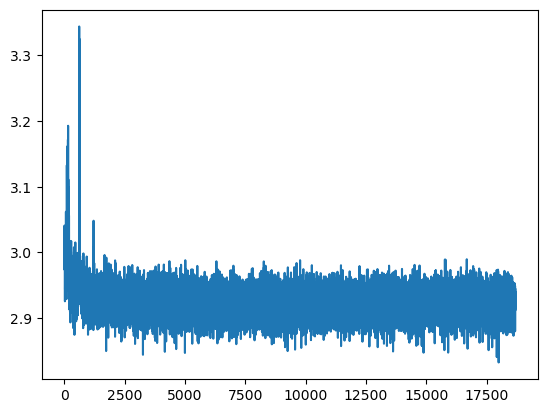

In [51]:
cst = ClassicalShadowTransformer(5,-4).load()
#print(cst.transformer.repara.logvar)
plt.plot(cst.loss_history[100:])

### Fine Tuning

If necessary, a model can be loaded for fine tuning with smaller training rate to ensure convergence.

In [213]:
cst = ClassicalShadowTransformer(5, -6).load()

In [39]:
cst.optimize(1000, max_steps=10000, nsr=32, window=1000, n_sample=1000, lr=0.00001)

./model/CST_d64_h16_l1/GHZ_N5_b-4
  0:  2.88058 -2.87172  0.14175 -0.28658


## Evaluation

### Loss Function History

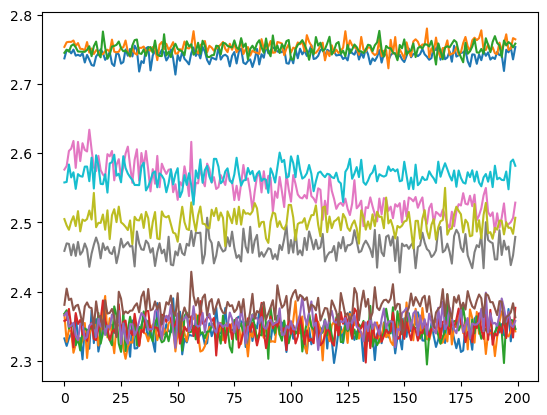

In [19]:
for logbeta in range(-6,7):
    cst = ClassicalShadowTransformer(4,logbeta).load()
    plt.plot(cst.loss_history[-200:])

### Fidelity and Entropy Map

Compute fidelity and entropy (in unit of bit) of the reconstructed density matrix.

In [84]:
data = []
for n_qubit in range(1, 6):
    for logbeta in range(-6, 7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
        fid = fid.real.item()
        vals = torch.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -torch.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])

./model/CST_d64_h16_l1/GHZ_N5_b6
F = 0.06341645121574402, S = 4.413326740264893


In [78]:
with open('./data/map.dat', 'wb') as f:
    pickle.dump(data, f)

Fidelity for 6 qubits (and beyond) can only be estimated by classical shadow tomography. First, prepare the GHZ state density matrix and convert it to Operator class.

In [26]:
rho = qst.ghz_state(6).density_matrix
tok = rho.tokenize()
paulis = tok[:,:-1]
coeffs = (9.-2.*tok[:,-1]) * rho.cs
rho = Operator(torch.tensor(paulis), torch.tensor(coeffs))

Then evaluate the expectation value of the density matrix on the classical shadow ensemble.

In [33]:
#data = []
for logbeta in range(2, 7):
    cst = ClassicalShadowTransformer(6, logbeta, embed_dim=128, n_layers=2).load().eval();
    clear_output(wait=True)
    print(cst.path + '/' + cst.file)
    fids = []
    for _ in range(5):
        shd = cst.sample(100000)
        fid = rho.expectation(shd, batch_size=1000).real.item()
        print(f'F = {fid:8.5f}')
        fids.append(fid)
    data.append([6, logbeta, fids])

./model/CST_d128_h16_l2/GHZ_N6_b6
F =  0.08763
F =  0.06920
F =  0.06147
F =  0.07483
F =  0.07469


In [35]:
with open('./data/fid6_d128_l2.dat', 'wb') as f:
    pickle.dump(data, f)

### Atlas Boreas Cygnus

Take three representative models.

In [44]:
mdls = {
    'atlas': ClassicalShadowTransformer(5, -5).load().eval(),
    'boreas': ClassicalShadowTransformer(5, -1).load().eval(),
    'cygnus': ClassicalShadowTransformer(5, 6).load().eval()}

Chat with the model. Dictionary:

| Number | Symbol |
|--------|--------|
| `1`    | `+`    |
| `2`    | `-`    |
| `3`    | `I`    |
| `4`    | `X`    |
| `5`    | `Y`    |
| `6`    | `Z`    |

* Z-test: `x: ZZZZZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* X-test: `x: XXXXX, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* XZ-test: `x: XXXXZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 

Collect data:

In [61]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/z_test.dat', 'wb') as f:
    pickle.dump(data, f)

In [62]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/x_test.dat', 'wb') as f:
    pickle.dump(data, f)

In [63]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
x[:,-1] = 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/xz_test.dat', 'wb') as f:
    pickle.dump(data, f)

### Density Matrix Reconstruction

Reconstruct density matrices for representative models.

In [65]:
data = {}
for name, mdl in mdls.items():
    with torch.no_grad():
        rho = mdl.rho().matrix_form()/2**mdl.n_qubit # reconstruction
    data[name] = rho.tolist()
with open('./data/rhos.dat', 'wb') as f:
    pickle.dump(data, f)

### Latent Space Structure

In [92]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
x = torch.cartesian_prod(*[torch.tensor([4,5,6])]*5)
data = {'x': (x-3).tolist()}
for name, mdl in mdls.items():
    with torch.no_grad():
        src = mdl.transformer.embed(x)
        mem = mdl.transformer.encode(src)
    mem = mem.view(mem.shape[0],-1)
    z = tsne.fit_transform(mem)
    data[name] = z.tolist()
with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)